In [1]:

from mri_loader import Subject
from nilearn.glm.first_level import FirstLevelModel

import pandas as pd
import numpy as np

from stats import *




In [2]:
subject_ids = [11, 12]

run_ids = list(range(1,5))

(subject_ids, run_ids)

([11, 12], [1, 2, 3, 4])

In [3]:

global_z_map = {"high - low": [], "undecided - high - low": []}

for subject in subject_ids:

    dataset = Subject(subject, run_ids)
    dataset.load()

    images, times, labels = dataset.get_data()
    low_inflexion, high_inflexion = dataset.compute_inflexions()

    print(f"{subject=} {low_inflexion=}, {high_inflexion=}")

    binned_labels = []

    labels_class = set(labels)

    for item in labels:
        key_numeric = item / 100

        if key_numeric < low_inflexion:
            binned_labels.append("low")

        elif key_numeric > high_inflexion:
            binned_labels.append("high")

        else:
            binned_labels.append("undecided")

    events = pd.DataFrame(
        {'onset': times,
         'trial_type': binned_labels,
         'duration': 2.5}
    )

    repetition_time = dataset.repetition_time
    fmri_glm = FirstLevelModel(t_r=repetition_time,
              drift_model='polynomial',
              drift_order=3,
              hrf_model='spm',
              mask_img=dataset.brain_mask,
              smoothing_fwhm=6,
              n_jobs=-1)

    fmri_glm = fmri_glm.fit(images, events)

    design_matrix = fmri_glm.design_matrices_[0]

    contrast_matrix = np.eye(design_matrix.shape[1])
    contrasts = {
        column: contrast_matrix[i]
        for i, column in enumerate(design_matrix.columns)
    }

    glm_contrast_high_low = contrasts["high"] - contrasts["low"]
    z_score_high = fmri_glm.compute_contrast(glm_contrast_high_low, output_type="z_score")

    global_z_map["high - low"].append(z_score_high)

    glm_contrast_undecided = contrasts["undecided"] - contrasts["high"] - contrasts["low"]
    z_score_undecided = fmri_glm.compute_contrast(glm_contrast_undecided, output_type="z_score")

    global_z_map["undecided - high - low"].append(z_score_undecided)




subject=11 low_inflexion=np.float64(0.2743243243243243), high_inflexion=np.float64(0.7247747747747747)
subject=12 low_inflexion=np.float64(0.2743243243243243), high_inflexion=np.float64(0.7247747747747747)


In [4]:
global_z_map

{'high - low': [<nibabel.nifti1.Nifti1Image at 0x2305bbe49a0>,
 'undecided - high - low': [<nibabel.nifti1.Nifti1Image at 0x2305adac8b0>,
  <nibabel.nifti1.Nifti1Image at 0x2305bbe65c0>]}

In [5]:
from nilearn.image import concat_imgs

global_z_mean = {}

for key, images in global_z_map.items():
    global_z_mean[key] = concat_imgs(global_z_map[key])

In [6]:
global_z_map

{'high - low': [<nibabel.nifti1.Nifti1Image at 0x2305bbe49a0>,
 'undecided - high - low': [<nibabel.nifti1.Nifti1Image at 0x2305adac8b0>,
  <nibabel.nifti1.Nifti1Image at 0x2305bbe65c0>]}

In [7]:
from nilearn.glm.second_level import SecondLevelModel


condition_effect = np.hstack(([1] * 2, [-1] * 2))
unpaired_design_matrix = pd.DataFrame(
    condition_effect[:, np.newaxis], columns=["C1 vs C2"]
)

second_level_input = global_z_map["high - low"] + global_z_map["undecided - high - low"]

second_level_model_unpaired = SecondLevelModel().fit(
    second_level_input, design_matrix=unpaired_design_matrix
)

stat_maps_unpaired = second_level_model_unpaired.compute_contrast(
    "C1 vs C2", output_type="all"
)

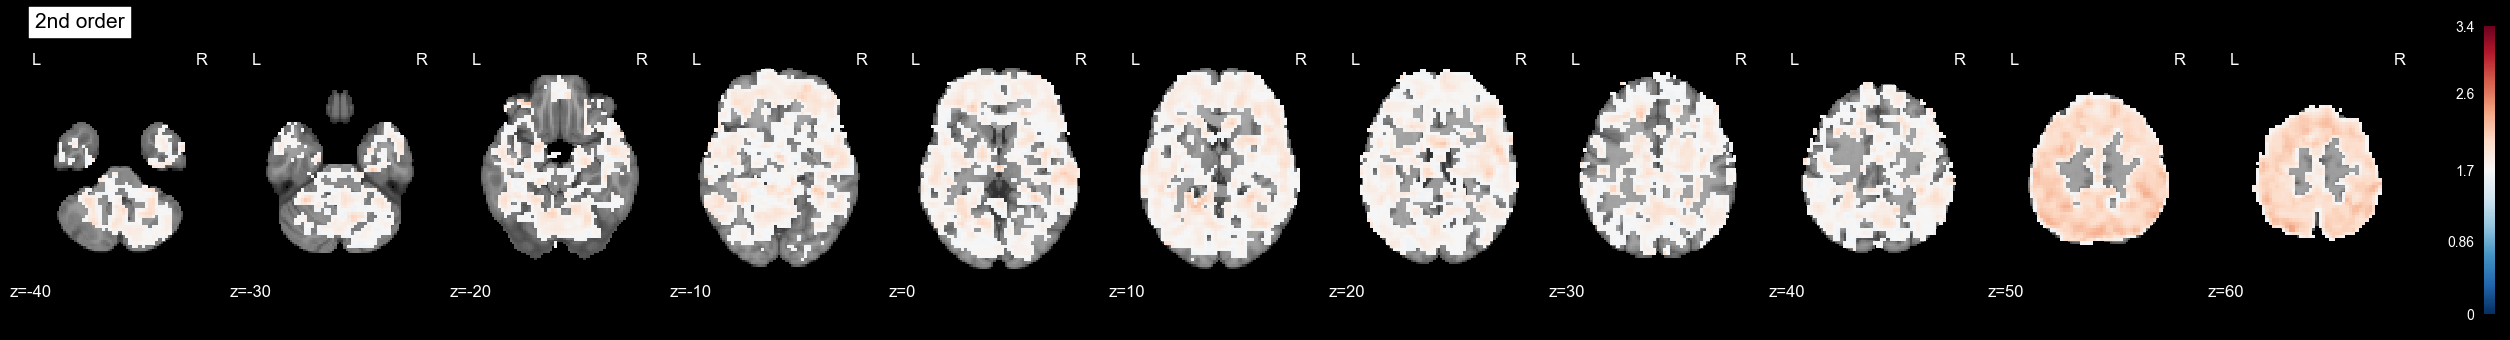

In [8]:
from nilearn.plotting import plot_stat_map
from nilearn.glm import threshold_stats_img

clean_z, threshold = threshold_stats_img(stat_maps_unpaired["z_score"], alpha=0.1, height_control="fpr")

plot_stat_map(
    clean_z,
    display_mode="z",
    title="2nd order",
    cut_coords=np.arange(-40, 70, 10),
    black_bg=True,
)


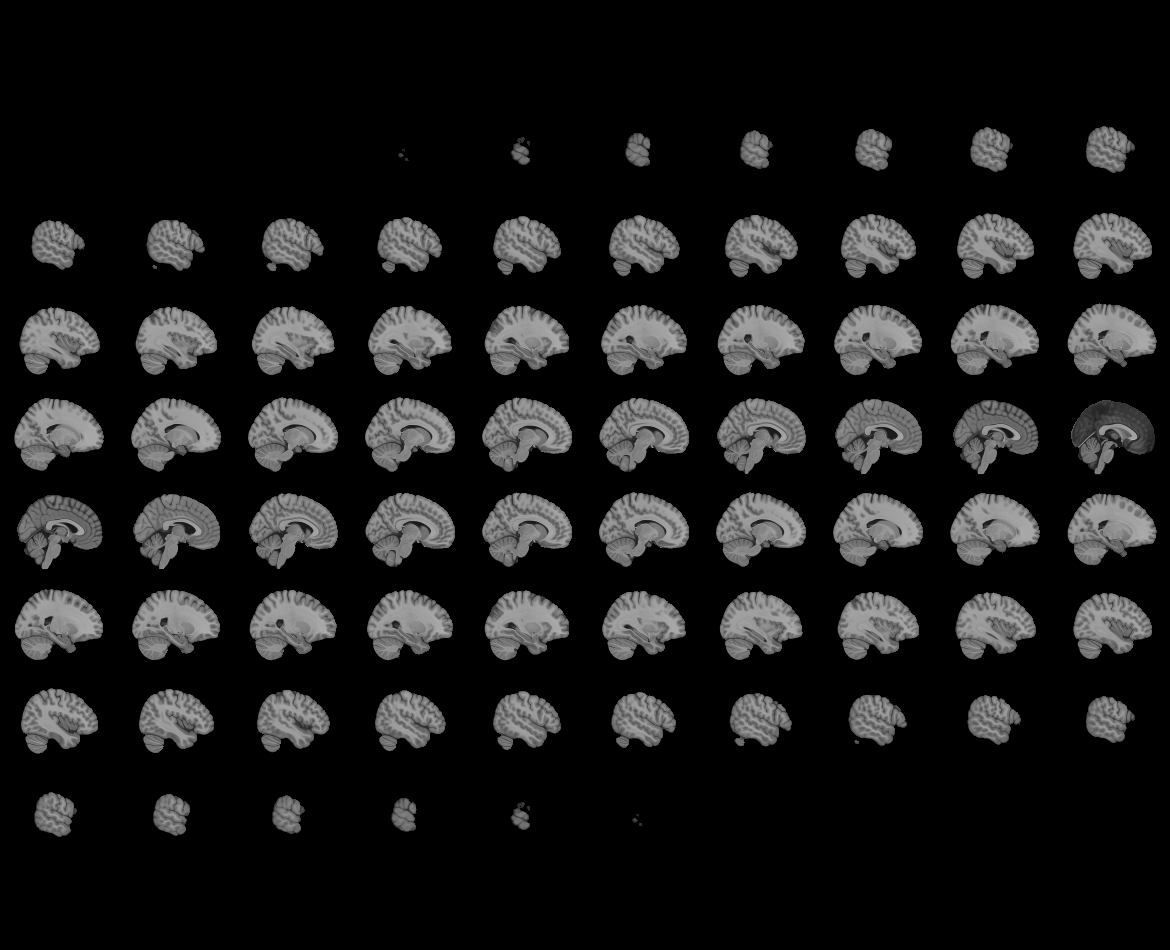
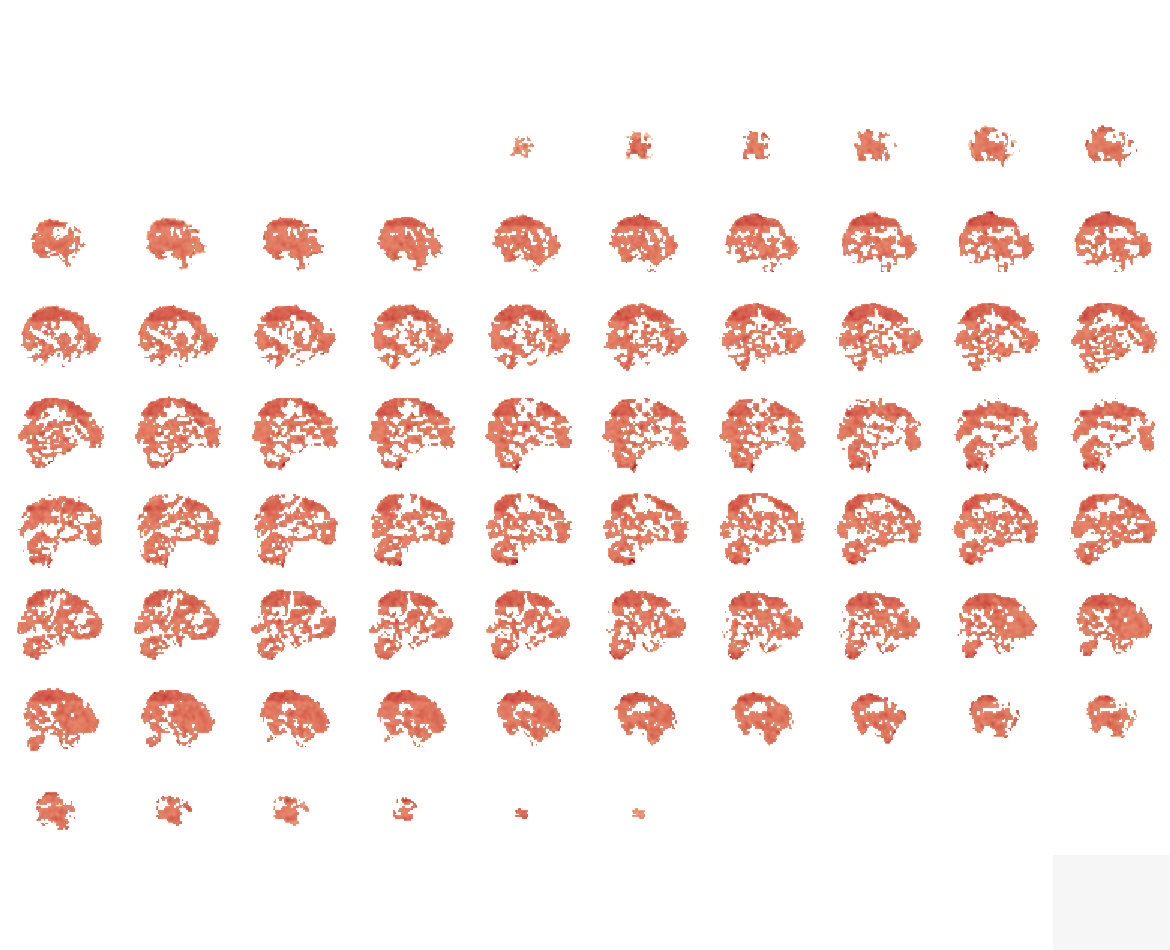

In [9]:
from nilearn.plotting import view_img

view_img(stat_maps_unpaired['z_score'], threshold=threshold)

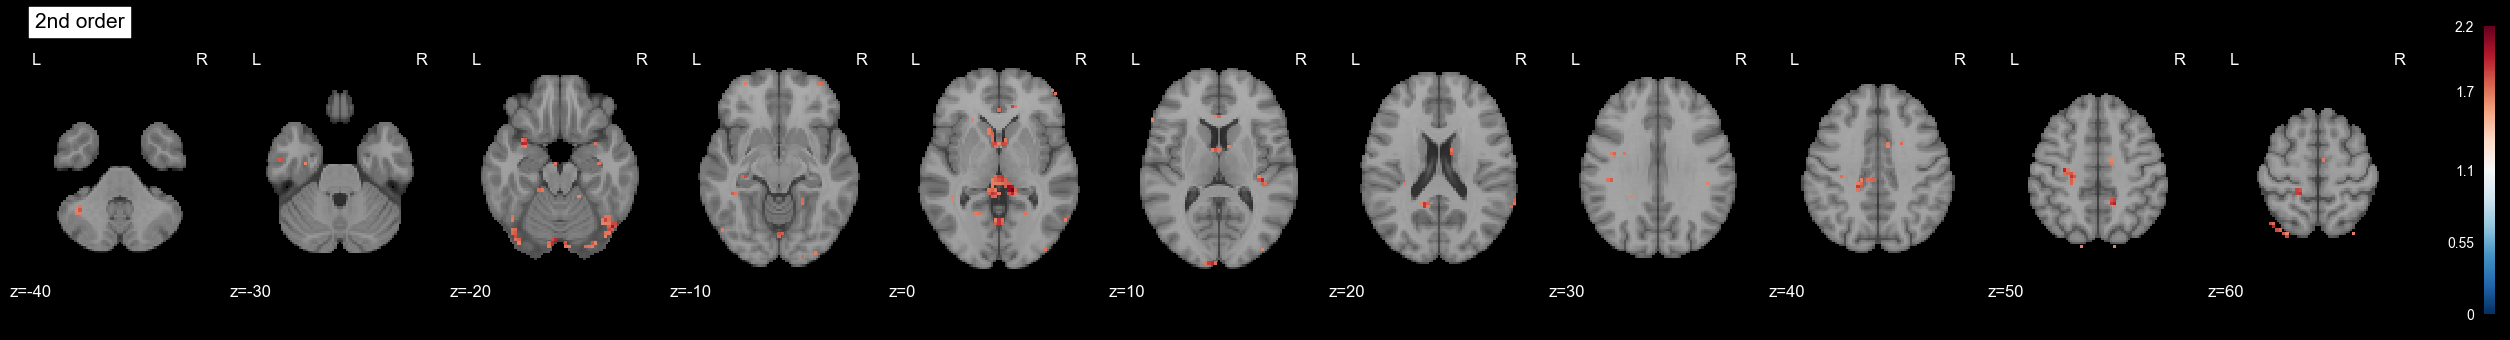

In [20]:
from nilearn import image

clean_z, threshold = threshold_stats_img(image.mean_img(global_z_mean["high - low"]), alpha=0.1, height_control="fpr")

plot_stat_map(
    clean_z,
    display_mode="z",
    title="2nd order",
    cut_coords=np.arange(-40, 70, 10),
    black_bg=True,
)
